In [15]:
%pip install --upgrade diffusers accelerate transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 文生图

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

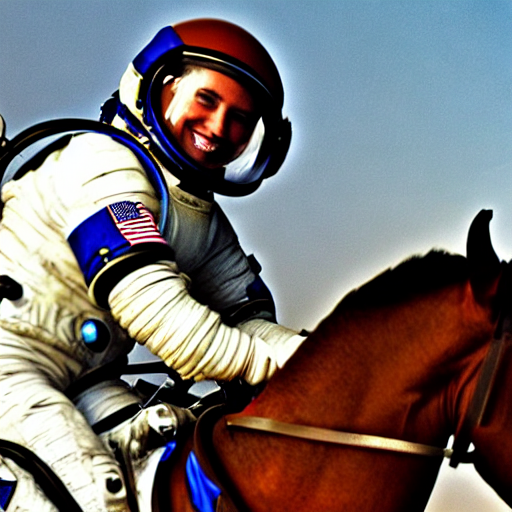

In [ ]:
from diffusers import DiffusionPipeline
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipeline.to("cuda")
image = pipeline("a photograph of an astronaut riding a horse").images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

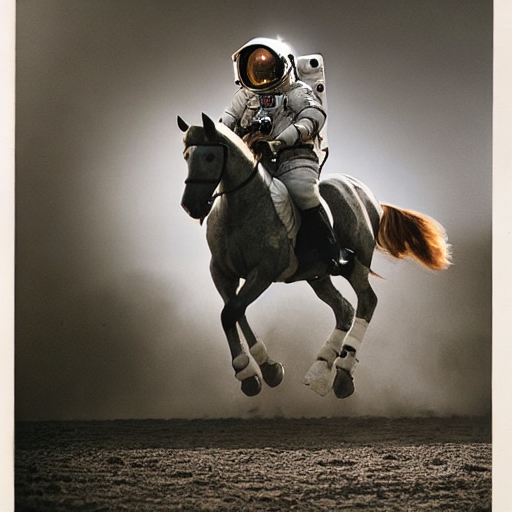

In [ ]:
image = pipeline("a photograph of an astronaut riding a horse").images[0]
image

In [ ]:
pipeline

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.15.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## StableDiffusion模块拆解

### 加载模型

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")
scheduler = PNDMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.self_attn.k_proj.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.weight', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.layer_norm1.bias', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.22.layer_norm1.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.12.self_attn.k_proj.weight', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.self_attn.out_proj.bi

In [5]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

### 生成图片的输入参数

In [54]:
import torch

prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(42)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

### 生成 Text Embedding

In [55]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [56]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

<ipython-input-56-007cfaacb096>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [57]:
latents = latents * scheduler.init_noise_sigma

In [58]:
import PIL
import torch
import numpy as np
from PIL import Image
from IPython.display import display

def display_denoised_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Denoised Sample @ Step {i}")
    display(image_pil)
    return image_pil

def display_decoded_image(latents, i):
  # scale and decode the image latents with vae
  latents = 1 / 0.18215 * latents
  with torch.no_grad():
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(f"Decoded Image @ step {i}")
    display(pil_images[0])
    return pil_images[0]


  0%|          | 0/26 [00:00<?, ?it/s]

'Denoised Sample @ Step 0'

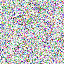

'Decoded Image @ step 0'

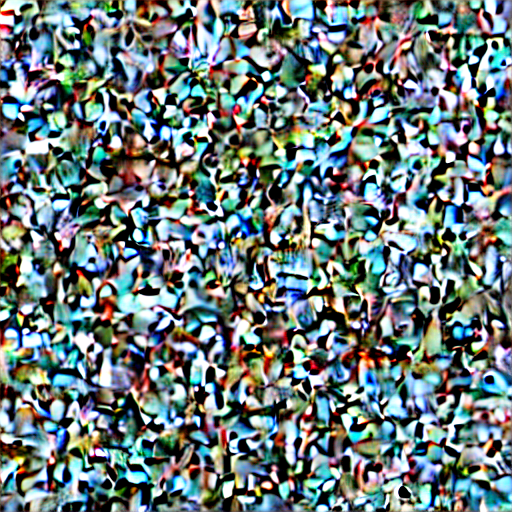

'Denoised Sample @ Step 5'

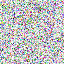

'Decoded Image @ step 5'

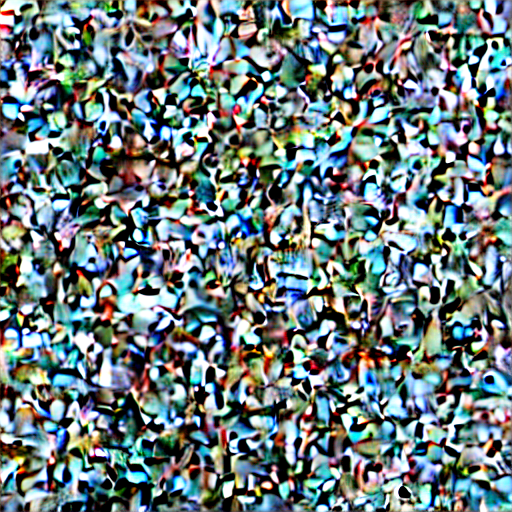

'Denoised Sample @ Step 10'

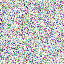

'Decoded Image @ step 10'

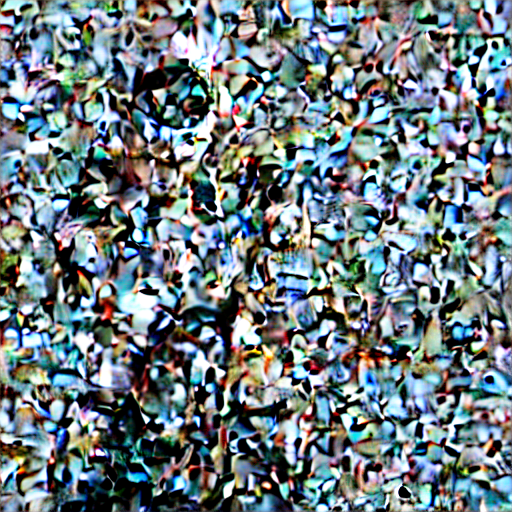

'Denoised Sample @ Step 15'

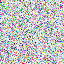

'Decoded Image @ step 15'

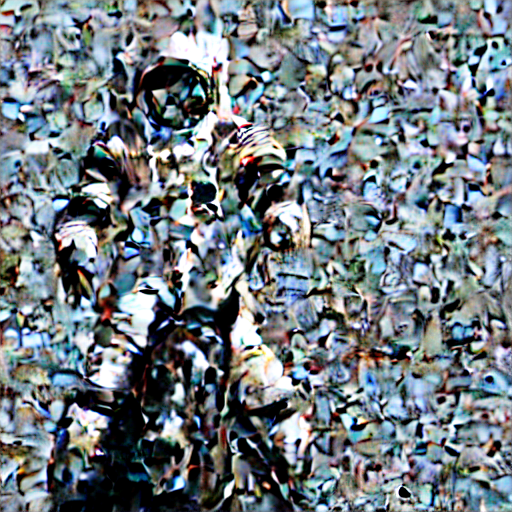

'Denoised Sample @ Step 20'

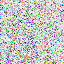

'Decoded Image @ step 20'

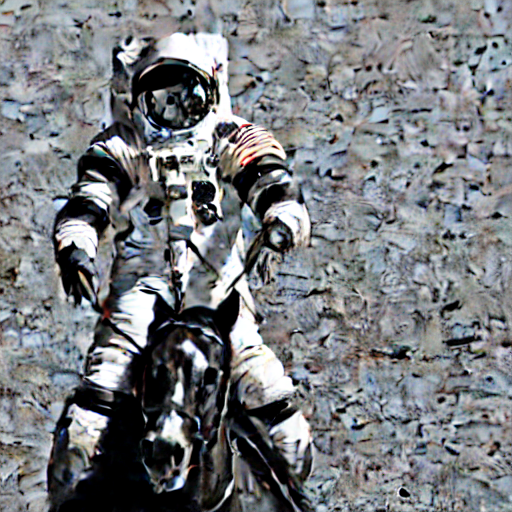

'Denoised Sample @ Step 25'

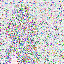

'Decoded Image @ step 25'

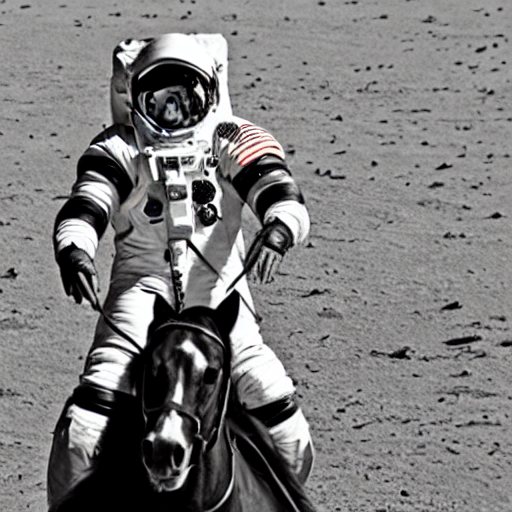

In [59]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

denoised_images = []
decoded_images = []
for i, t in enumerate(tqdm(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    if i % 5 == 0:
      denoised_image = display_denoised_sample(latents, i)
      decoded_image = display_decoded_image(latents, i)
      denoised_images.append(denoised_image)
      decoded_images.append(decoded_image)

In [63]:
print(latents.shape)
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
print(image.shape)

torch.Size([1, 4, 64, 64])
torch.Size([1, 3, 512, 512])


## 图生图（Image-to-Image）

In [1]:
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

image_file = "./data/sketch-mountains-input.jpg"

init_image = Image.open(image_file).convert("RGB")
init_image = init_image.resize((768, 512))

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [2]:
prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

  0%|          | 0/37 [00:00<?, ?it/s]

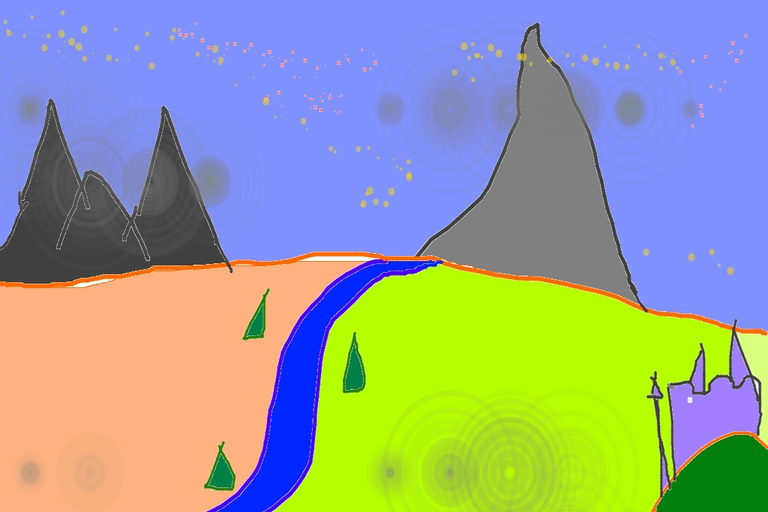

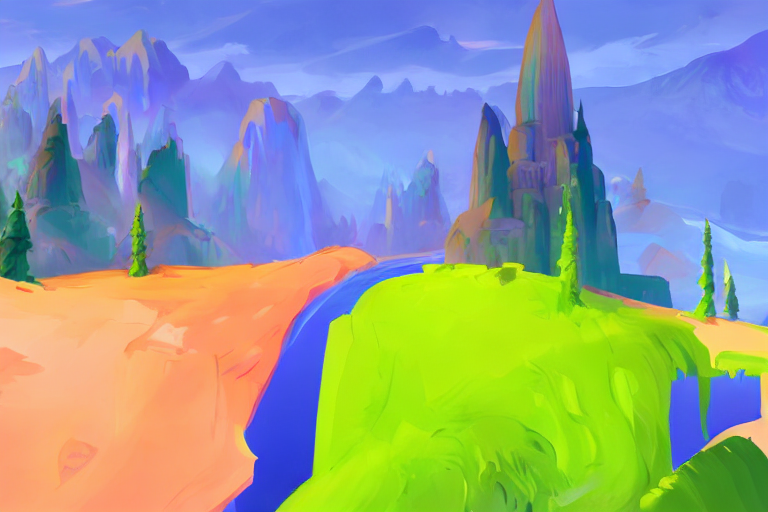

In [3]:
display(init_image)
display(images[0])

In [71]:
prompt = "ghibli style, a fantasy landscape with castles"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

  0%|          | 0/37 [00:00<?, ?it/s]

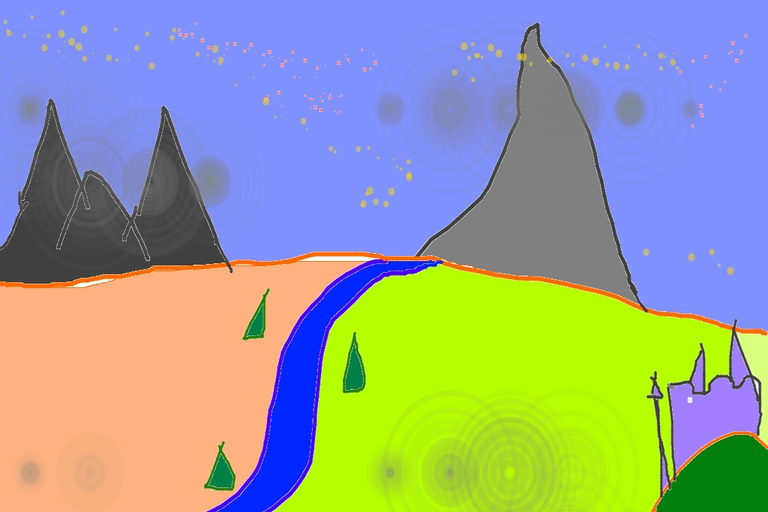

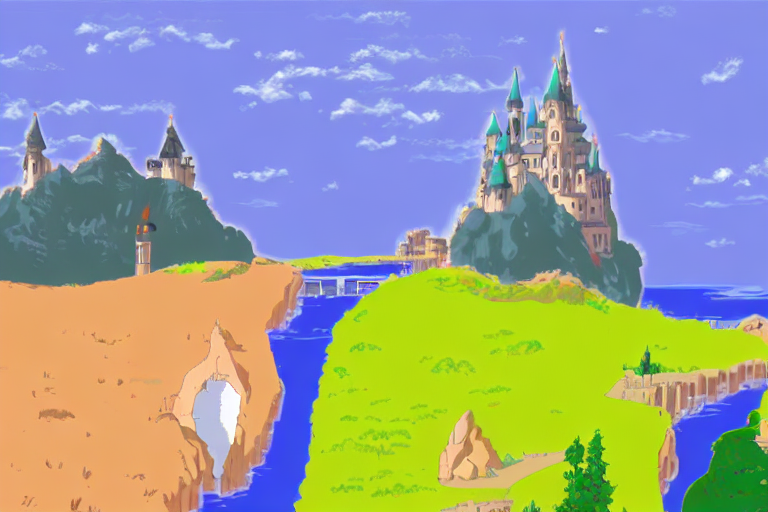

In [72]:
display(init_image)
display(images[0])

## Negative Prompt

  0%|          | 0/37 [00:00<?, ?it/s]

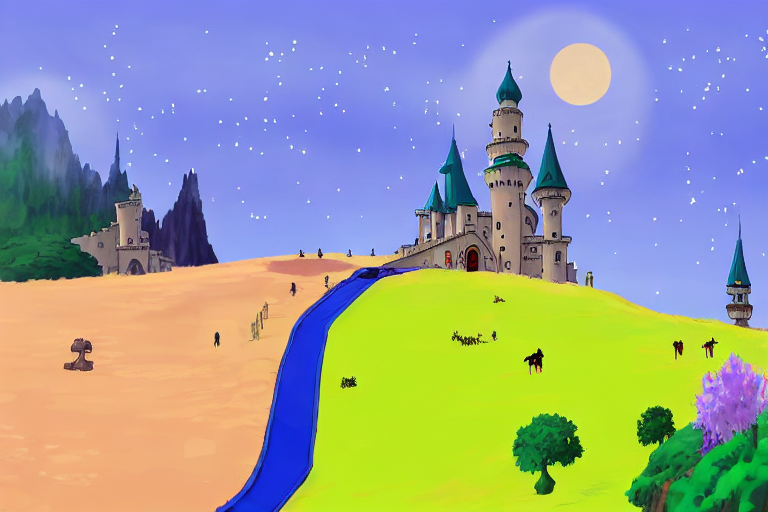

In [7]:
prompt = "ghibli style, a fantasy landscape with castles"
negative_prompt = "river"
images = pipe(prompt=prompt, negative_prompt=negative_prompt, image=init_image, strength=0.75, guidance_scale=7.5).images

display(images[0])

  0%|          | 0/75 [00:00<?, ?it/s]

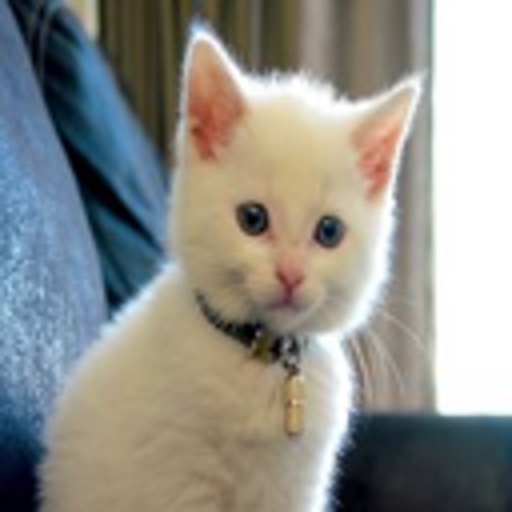

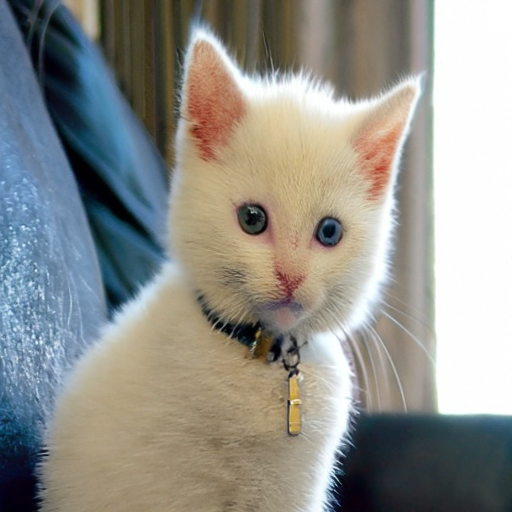

In [11]:
from diffusers import StableDiffusionUpscalePipeline

# load model and scheduler
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(
    model_id, revision="fp16", torch_dtype=torch.float16
)
pipeline = pipeline.to("cuda")

# let's download an  image
low_res_img_file = "./data/low_res_cat.png"
low_res_img = Image.open(low_res_img_file).convert("RGB")
low_res_img = low_res_img.resize((128, 128))

prompt = "a white cat"

upscaled_image = pipeline(prompt=prompt, image=low_res_img).images[0]

low_res_img_resized = low_res_img.resize((512, 512))

display(low_res_img_resized)
display(upscaled_image)

In [12]:
pipeline

StableDiffusionUpscalePipeline {
  "_class_name": "StableDiffusionUpscalePipeline",
  "_diffusers_version": "0.15.1",
  "low_res_scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "max_noise_level": 350,
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## CIVITAI

In [1]:
from diffusers import DiffusionPipeline
pipeline = DiffusionPipeline.from_pretrained("gsdf/Counterfeit-V2.5")


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (86 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['dappled sunlight, day, depth of field']


  0%|          | 0/50 [00:00<?, ?it/s]

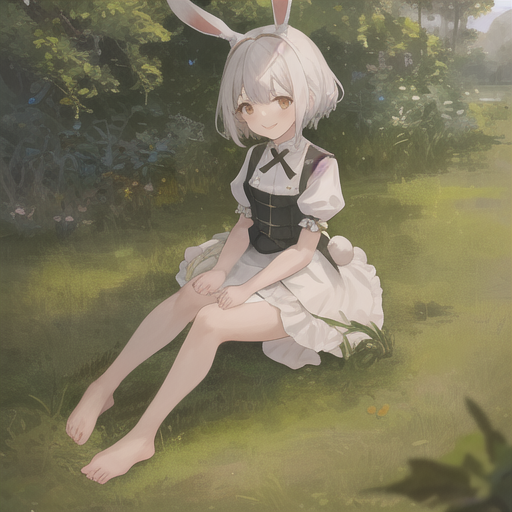

In [2]:
pipeline.to("cuda")

prompt = "((masterpiece,best quality)),1girl, solo, animal ears, rabbit, barefoot, knees up, dress, sitting, rabbit ears, short sleeves, looking at viewer, grass, short hair, smile, white hair, puffy sleeves, outdoors, puffy short sleeves, bangs, on ground, full body, animal, white dress, sunlight, brown eyes, dappled sunlight, day, depth of field"
negative_prompt = "EasyNegative, extra fingers,fewer fingers,"
image = pipeline(prompt=prompt, negative_prompt=negative_prompt).images[0]
image